In [ ]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## 2.2 Action-Value Methods

In [102]:
def plot_comparison(X, Ys, labels, title, xlabel, ylabel):
    plt.figure()
    for i, y in enumerate(Ys):
        plt.plot(np.arange(X), y, label=labels[i], alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle=':')
    plt.legend()
    plt.show()

In [113]:
def softmax(x, tau=1.0):
    x = np.array(x)
    z = x / tau
    z = z - np.max(z)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

### $\epsilon$-greedy method

In [55]:
num_A = 10
num_tasks = 1_000
num_episodes = 2_000
reward_mean = 0.5
reward_variance = 1

In [144]:
class ActionSelectionExperiment:
    def __init__(self, reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1_000):
        self.reward_mean=reward_mean
        self.reward_variance=reward_variance
        self.num_A=num_A
        self.num_tasks=num_tasks

In [ ]:
class EpsGreedyActionSelection(ActionSelectionExperiment):
    def __init__(self, reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1000):
        super().__init__(reward_mean, reward_variance, num_A, num_tasks)
    
    def run_episode(self, eps):
        # true action values Q*
        Q_star = np.random.normal(self.reward_mean, self.reward_variance, size=self.num_A)
        # estimated action values
        Q_est = np.zeros(self.num_A, dtype=np.float32)
        action_chosen_counts = np.zeros(self.num_A)
        optimal_choices = np.zeros(self.num_tasks) # bit array stating if action chosen at a play was the true best action
        reward_hist = []
        
        for play in range(self.num_tasks):
            if random.random() < eps:
                a_t = random.choice(range(0, self.num_A))
            else:
                a_t = np.argmax(Q_est)
            r_t = random.gauss(Q_star[a_t])
            reward_hist.append(r_t)
            
            if a_t == np.argmax(Q_star):
                optimal_choices[play] += 1

            k = action_chosen_counts[a_t] # times this action has been chosen            
            Q_est[a_t] += (r_t - Q_est[a_t]) / (k + 1)
            action_chosen_counts[a_t] += 1

        return np.array(reward_hist), optimal_choices
    
    def run_test(self, epsilons, num_episodes=2000):
        results = dict()
        for eps in epsilons:
            print(f"Running episode with eps={eps}")
            mean_reward_hist = np.zeros(self.num_tasks)
            mean_optimal_choice_hist = np.zeros(self.num_tasks)
            for epsiode in tqdm(range(num_episodes)):
                reward_hist, optimal_choice_hist = self.run_episode(eps)
                mean_reward_hist += reward_hist
                mean_optimal_choice_hist += optimal_choice_hist
            mean_reward_hist /= num_episodes
            mean_optimal_choice_hist /= num_episodes
            results[eps] = (mean_reward_hist, mean_optimal_choice_hist)
        return results

In [110]:
epsilons = [0, 0.1, 0.01]
eps_greedy_experiment = EpsGreedyActionSelection(reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1000)
eps_greedy_results = eps_greedy_experiment.run_test(epsilons, num_episodes=2000)

Running episode with eps=0


100%|██████████| 2000/2000 [00:21<00:00, 95.22it/s] 


Running episode with eps=0.1


100%|██████████| 2000/2000 [00:18<00:00, 108.85it/s]


Running episode with eps=0.01


100%|██████████| 2000/2000 [00:18<00:00, 105.49it/s]


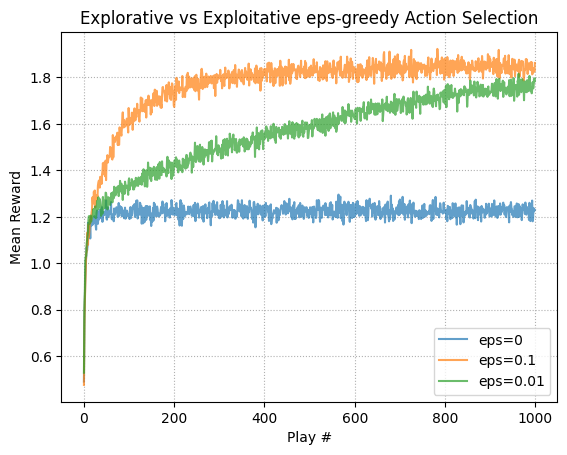

In [111]:
plot_comparison(X=1000, Ys=[i[0] for i in eps_greedy_results.values()],
                labels=[f"eps={eps}" for eps in epsilons],
                title="Explorative vs Exploitative eps-greedy Action Selection",
                xlabel="Play #",
                ylabel="Mean Reward")

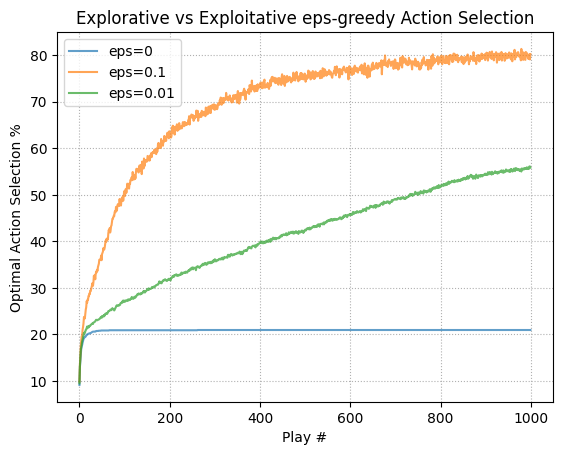

In [152]:
plot_comparison(X=1000, Ys=[i[1] * 100 for i in eps_greedy_results.values()],
                labels=[f"eps={eps}" for eps in epsilons],
                title="Explorative vs Exploitative eps-greedy Action Selection",
                xlabel="Play #",
                ylabel="Optimal Action Selection %")

### Softmax Action-Selection

In [114]:
class SoftmaxActionSelection(ActionSelectionExperiment):
    def __init__(self, reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1000):
        super().__init__(reward_mean, reward_variance, num_A, num_tasks)
    
    def run_episode(self, temperature):
        Q_star = np.random.normal(self.reward_mean, self.reward_variance, size=self.num_A)
        Q_est = np.zeros(self.num_A, dtype=np.float32)
        action_chosen_counts = np.zeros(self.num_A)
        optimal_choices = np.zeros(self.num_tasks)
        reward_hist = []

        for play in range(self.num_tasks):
            # policy =  probability of choosing each action
            policy = softmax(Q_est, tau=temperature)
            a_t = np.random.choice(self.num_A, p=policy)
            r_t = random.gauss(Q_star[a_t])
            reward_hist.append(r_t)

            if a_t == np.argmax(Q_star):
                optimal_choices[play] += 1
            
            k = action_chosen_counts[a_t]
            Q_est[a_t] += (r_t - Q_est[a_t]) / (k + 1)
            action_chosen_counts[a_t] += 1
        return np.array(reward_hist), optimal_choices

    def run_test(self, temps, num_episodes=2000):
        results = dict()
        for temp in temps:
            print(f"Running episode with temperature={temp}")
            mean_reward_hist = np.zeros(self.num_tasks)
            mean_optimal_choice_hist = np.zeros(self.num_tasks)
            for episode in tqdm(range(num_episodes)):
                reward_hist, optimal_choice_hist = self.run_episode(temperature=temp)
                mean_reward_hist += reward_hist
                mean_optimal_choice_hist += optimal_choice_hist
            mean_reward_hist /= num_episodes
            mean_optimal_choice_hist /= num_episodes
            results[temp] = (mean_reward_hist, mean_optimal_choice_hist)
        return results
        

In [115]:
temperatures = [0.1, 1, 2]
softmax_experiment = SoftmaxActionSelection(reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=10000)
softmax_results = softmax_experiment.run_test(temps=temperatures, num_episodes=2000)

Running episode with temperature=0.1


100%|██████████| 2000/2000 [03:30<00:00,  9.50it/s]


Running episode with temperature=1


100%|██████████| 2000/2000 [03:04<00:00, 10.87it/s]


Running episode with temperature=2


100%|██████████| 2000/2000 [03:00<00:00, 11.06it/s]


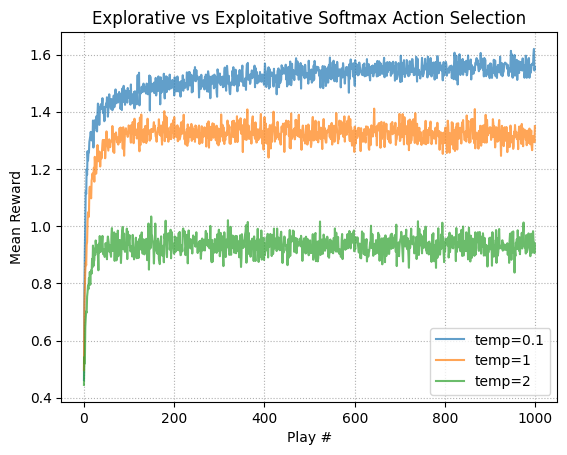

In [116]:
plot_comparison(X=1000, Ys=[i[0] for i in softmax_results.values()],
                labels=[f"temp={temp}" for temp in temperatures],
                title="Explorative vs Exploitative Softmax Action Selection",
                xlabel="Play #",
                ylabel="Mean Reward")

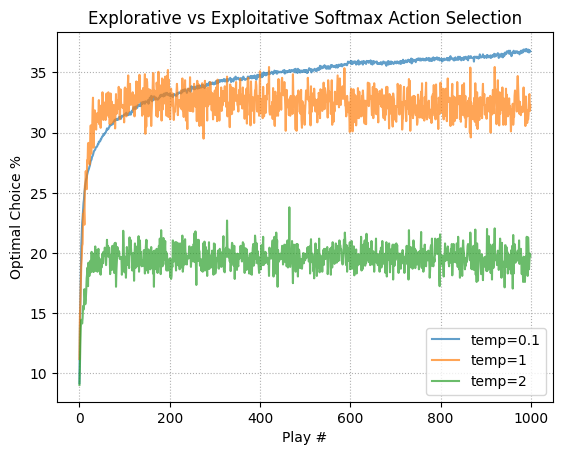

In [151]:
plot_comparison(X=1000, Ys=[i[1] * 100 for i in softmax_results.values()],
                labels=[f"temp={temp}" for temp in temperatures],
                title="Explorative vs Exploitative Softmax Action Selection",
                xlabel="Play #",
                ylabel="Optimal Choice %")

## Non-Stationary Problems

### Sutton & Barto, Exercise 2.7 
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have on nonstationary problems. Use a modified version of the 10-armed testbed in which all the $Q^{*}(a)$ start out equal and then take independent random walks. Prepare  plots like Figure 2.1 for an action-value method using sample averages, incrementally computed by $\alpha=\frac{1}{k}$, and another action-value method using a constant step size, $\alpha=0.1$. Use ${\epsilon=.1}$ and, if necessary, runs longer than 1000 plays.

In [153]:
class NonStationaryBandit(ActionSelectionExperiment):
    def __init__(self, reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1000):
        super().__init__(reward_mean, reward_variance, num_A, num_tasks)
    
    def run_episode(self, eps, with_alpha, alpha, perturbation_variance=0.01):
        Q_star = np.random.normal(self.reward_mean, self.reward_variance, size=self.num_A)
        Q_est = np.zeros(num_A, dtype=np.float32)
        action_chosen_counts = np.zeros(self.num_A)
        optimal_choices = np.zeros(self.num_tasks)
        reward_hist = []

        for play in range(self.num_tasks):
            Q_star += np.random.normal(0, perturbation_variance, size=self.num_A)
            if random.random() < eps:
                a_t = np.random.choice(self.num_A)
            else:
                a_t = np.argmax(Q_est)

            if a_t == np.argmax(Q_star):
                optimal_choices[play] += 1

            r_t = random.gauss(Q_star[a_t])                
            reward_hist.append(r_t)
            k = action_chosen_counts[a_t]
            if with_alpha:
                Q_est[a_t] += alpha * (r_t - Q_est[a_t])
            else:
                Q_est[a_t] += (r_t - Q_est[a_t]) / (k + 1)
            action_chosen_counts[a_t] += 1
        return np.array(reward_hist), optimal_choices
    
    def run_test(self, with_alpha, perturbation_variance=0.01, num_epsides=2000):
        if with_alpha:
            print(f"Running task with alpha={0.1} & eps=0.1")
        else:
            print(f"Running task with alpha=1/k & eps=0.1")
        mean_reward_hist = np.zeros(self.num_tasks)
        mean_optimal_choice_hist = np.zeros(self.num_tasks)
        for task in tqdm(range(num_episodes)):
            reward_hist, optimal_choice_hist = self.run_episode(0.1, with_alpha, 0.1, perturbation_variance=perturbation_variance) 
            mean_reward_hist += reward_hist
            mean_optimal_choice_hist += optimal_choice_hist
        mean_reward_hist /= num_episodes
        mean_optimal_choice_hist /= num_episodes
        return mean_reward_hist, mean_optimal_choice_hist
            

In [154]:
non_stationary_w_sample_mean = NonStationaryBandit(reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1500)
non_stationary_w_constant_step = NonStationaryBandit(reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1500)
non_stationary_results = {
    "sample_mean": non_stationary_w_sample_mean.run_test(with_alpha=False, num_epsides=2000),
    "constant_step": non_stationary_w_constant_step.run_test(with_alpha=True, num_epsides=2000) 
    }


Running task with alpha=1/k & eps=0.1


100%|██████████| 2000/2000 [01:10<00:00, 28.24it/s]


Running task with alpha=0.1 & eps=0.1


100%|██████████| 2000/2000 [01:18<00:00, 25.55it/s]


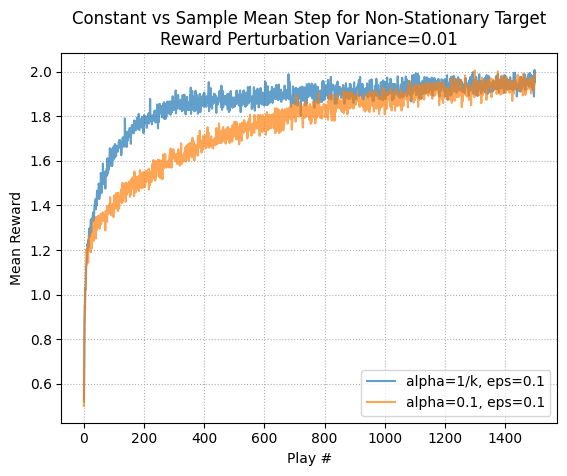

In [175]:
plot_comparison(X=1500, Ys=[i[0] for i in non_stationary_results.values()],
                labels=("alpha=1/k, eps=0.1", "alpha=0.1, eps=0.1"),
                title="Constant vs Sample Mean Step for Non-Stationary Target\nReward Perturbation Variance=0.01",
                xlabel="Play #",
                ylabel="Mean Reward")

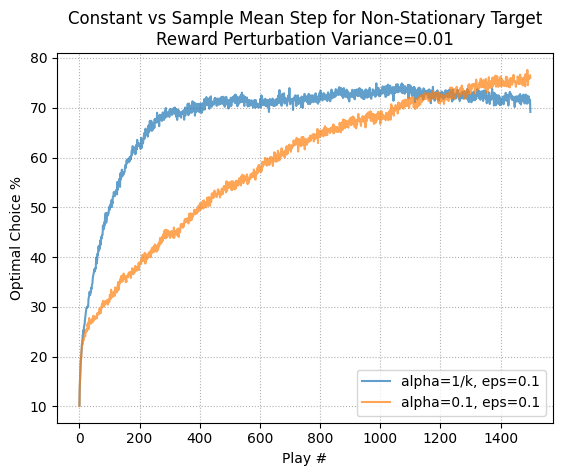

In [176]:
plot_comparison(X=1500, Ys=[i[1] * 100 for i in non_stationary_results.values()],
                labels=("alpha=1/k, eps=0.1", "alpha=0.1, eps=0.1"),
                title="Constant vs Sample Mean Step for Non-Stationary Target\nReward Perturbation Variance=0.01",
                xlabel="Play #",
                ylabel="Optimal Choice %")

## Reinforcement Comparison Methods

In [170]:
class ReinforcementComparison(ActionSelectionExperiment):
    def __init__(self, reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1000):
        super().__init__(reward_mean, reward_variance, num_A, num_tasks)

    def run_episode(self, beta=0.1, alpha=0.1, init_ref_reward=0, perturbation_variance=0.01):
        action_prefs = np.zeros(self.num_A)
        ref_reward = init_ref_reward
        Q_star = np.random.normal(self.reward_mean, self.reward_variance, size=self.num_A)
        reward_hist = []
        optimal_choices = np.zeros(self.num_tasks)
    
        for play in range(self.num_tasks):
            Q_star += np.random.normal(0, perturbation_variance, size=self.num_A)

            # policy is now a distribution over preferences rather than value estimates
            policy = softmax(action_prefs)
            a_t = np.random.choice(self.num_A, p=policy)

            if a_t == np.argmax(Q_star):
                optimal_choices[play] += 1
            
            r_t = np.random.normal(Q_star[a_t])
            reward_hist.append(r_t)

            # update preferences and reference reward
            action_prefs[a_t] += beta * (r_t - ref_reward) * (1 - policy[a_t])
            ref_reward += alpha * (r_t - ref_reward)

        return np.array(reward_hist), optimal_choices 
    
    def run_test(self, beta=0.1, alpha=0.1, perturbation_variance=0.01, num_episodes=2000):
        mean_reward_hist = np.zeros(self.num_tasks)
        mean_optimal_choice_hist = np.zeros(self.num_tasks)
        for episode in tqdm(range(num_episodes)):
            reward_hist, optimal_choices = self.run_episode(beta, alpha, init_ref_reward=0, perturbation_variance=perturbation_variance)
            mean_reward_hist += reward_hist
            mean_optimal_choice_hist += optimal_choices
        mean_reward_hist /= num_episodes
        mean_optimal_choice_hist /= num_episodes
        return mean_reward_hist, mean_optimal_choice_hist


In [171]:
reinforcement_comparison_exp = ReinforcementComparison(reward_mean=0.5, reward_variance=1, num_A=10, num_tasks=1500)
reinforcement_comp_result = reinforcement_comparison_exp.run_test(beta=0.1, alpha=0.1, perturbation_variance=0.01)

100%|██████████| 2000/2000 [03:58<00:00,  8.38it/s]


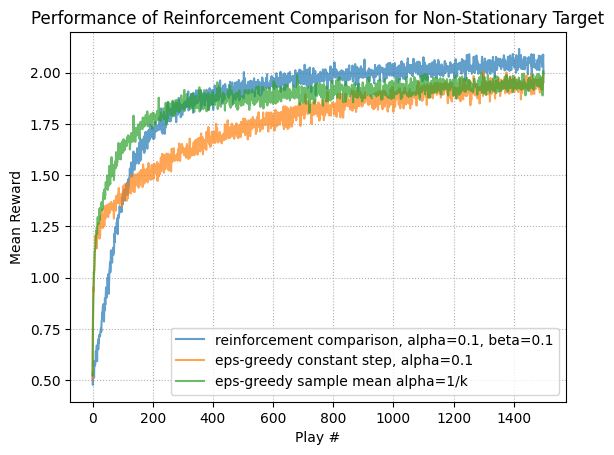

In [172]:
plot_comparison(1500,
                Ys=(
                    reinforcement_comp_result[0],
                    non_stationary_results['constant_step'][0],
                    non_stationary_results['sample_mean'][0],
                ),
                labels=("reinforcement comparison, alpha=0.1, beta=0.1",
                        "eps-greedy constant step, alpha=0.1",
                        "eps-greedy sample mean alpha=1/k"),
                title="Performance of Reinforcement Comparison for Non-Stationary Target",
                xlabel="Play #",
                ylabel="Mean Reward")

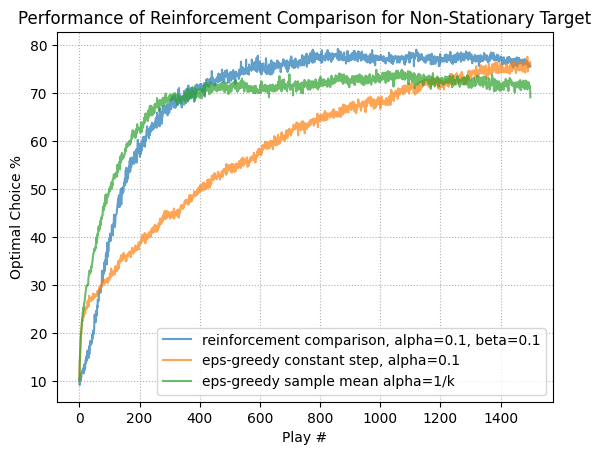

In [174]:
plot_comparison(1500,
                Ys=(
                    reinforcement_comp_result[1] * 100,
                    non_stationary_results['constant_step'][1] * 100,
                    non_stationary_results['sample_mean'][1] * 100,
                ),
                labels=("reinforcement comparison, alpha=0.1, beta=0.1",
                        "eps-greedy constant step, alpha=0.1",
                        "eps-greedy sample mean alpha=1/k"),
                title="Performance of Reinforcement Comparison for Non-Stationary Target",
                xlabel="Play #",
                ylabel="Optimal Choice %")